# DrivenData: Heart disease prediction using Logistic Regression and SVM

###### BY ANNE DE GRAAF

This notebook is meant to show my train of thoughts during the development of prediction model for the heart disease warm-up exercise on DrivenData.org. 

Prior to writing this notebook I had already evaluated the data set and applied z-score normalization to the numerical data and one-hot encoding to the categorical data (see also "data_processing.py" in this repository).

The final score of my logistic regression model was 0.32931, which was 16th place at the time of submitting.


[keywords: logistic regression, SVM, crossvalidation, bias, variance, k-fold, stratified k-fold, leave-p-out]

In [97]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, SVR
import pandas as pd 
import numpy as np 
from functions import logLoss, logLoss2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [2]:
# load training data
allFeatures = pd.read_csv('../train_values_normalized.csv', index_col=0)
y = pd.read_csv('../train_labels.csv', index_col=0)

### First model: using 6 input features

In [3]:
# selection of input features to use in this model:
useCols = ['resting_blood_pressure','age','chestPain_1',
           'chestPain_2','chestPain_3','chestPain_4']
X = allFeatures[useCols]

# split the train set in train and crossval set
X_train, X_cross, y_train, y_cross = train_test_split(X, y, 
                                test_size=0.3, random_state=0)

# apply logistic regression and predict crossval set
logResModel = LogisticRegression(penalty='l1', tol=1e-8, solver='liblinear').fit(X_train, 
                                                np.ravel(y_train))
prob = logResModel.predict_proba(X_cross)
loss = logLoss(y_cross, prob)[0,1]
num_iter = logResModel.n_iter_
print('log loss on crossval set is: %0.5f' %loss)
print('after %d iterations' %num_iter)

log loss on crossval set is: 0.55285
after 33 iterations


This log loss value is bit higher than the "Logistic Regression Benchmark" of 0.5381 (based on TEST set) on the competition's leader board. (high log loss value == not good)
##### So let's perform some error analysis to see what we can improve

### Comparing loss on crossval set and loss on training set:

In [4]:
trainProb = logResModel.predict_proba(X_train)
trainLoss = logLoss(y_train, trainProb)[0,1]
print('log loss on training set is: %0.5f' %trainLoss)

log loss on training set is: 0.55705


The error on the training set is high too, so this indicates we have a bias (underfit) problem. This was to be expected as I only used a very limited amount of features.

Let's make a model with all the available input features.

### Second model: using all input features

In [5]:
# split the train set in train and crossval set
X_train, X_cross, y_train, y_cross = train_test_split(allFeatures, y, 
                                test_size=0.3, random_state=0)

# apply logistic regression and predict crossval set
logResModel2 = LogisticRegression(penalty='l1', tol=1e-8, solver='liblinear').fit(X_train, 
                                                np.ravel(y_train))
prob = logResModel2.predict_proba(X_cross)
loss = logLoss(y_cross, prob)[0,1]
num_iter = logResModel2.n_iter_
print('log loss on crossval set is: %0.5f' %loss)
print('after %d iterations' %num_iter)

trainProb2 = logResModel2.predict_proba(X_train)
trainLoss2 = logLoss(y_train, trainProb2)[0,1]
print('log loss on training set is: %0.5f' %trainLoss2)

log loss on crossval set is: 0.52440
after 30 iterations
log loss on training set is: 0.31098


Before we evaluate these results, let's apply the model to the test set and upload the results to DrivenData to see our score.

In [6]:
# loading test data
X_test = pd.read_csv('../test_values_normalized.csv', index_col=0)
prob_test = logResModel2.predict_proba(X_test)[:,1]

# saving test results
d = {'heart_disease_present': prob_test}
submission_df = pd.DataFrame(data=d, index=X_test.index)
submission_df.to_csv('../logResModel2_results.csv')

log loss on the test set is: 0.3757

This is quite a higher score than the "Logistic Regression Benchmark".

However, the gap between our performance on the crossval set and the training set is hugely increased. 
This points towards a high variance problem (or overfitting). The funny thing is that our performance on the test set is a lot better however than the performance on the crossval set. This might be due to the fact that we used the simple holdout method for our crossvalidation: as our crossval set is quite small, its performance is highly dependent of which data points happen to end up in the set. So in fact, the performance on the crossval set doesn't tell us that much about the actual performance of the model on the test set (as indicated by the huge difference between the 0.3757 performance on the test set and the 0.5244 on the crossval set).

To obtain a more accurate indication of our performance on the crossval set, we will now perform k-fold cross-validation. Here, we will use k=10. We will apply normal k-fold and stratified k-fold, to see the effect of a more balanced crossvalidation set on the accuracy of our prediction.

### K-fold cross-validation (with k=10)

In [7]:
kFold = KFold(n_splits=10, shuffle=True, random_state=1)
X = allFeatures
crossVal_performance = np.zeros(kFold.get_n_splits())
i=int(0)
for iTrain, iCross in kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    model_i = LogisticRegression(penalty='l1', tol=1e-8, solver='liblinear').fit(X_train, np.ravel(y_train))
    prob_i = model_i.predict_proba(X_cross)
    crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
    i+=1
    
print('cross-validation performance on the 10 folds:', crossVal_performance)
print('mean cross-validation performance: %0.5f' %np.mean(crossVal_performance))

('cross-validation performance on the 10 folds:', array([1.00319695, 0.24600038, 0.39085666, 1.23460987, 0.4038797 ,
       0.37464708, 0.40883189, 0.26932168, 0.26362185, 0.24942142]))
mean cross-validation performance: 0.48444


### Stratified k-fold cross-validation (with k=10)

In [8]:
str_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
crossVal_performance = np.zeros(str_kFold.get_n_splits())
i=int(0)
for iTrain, iCross in str_kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    model_i = LogisticRegression(penalty='l1', tol=1e-8, solver='liblinear').fit(X_train, np.ravel(y_train))
    prob_i = model_i.predict_proba(X_cross)
    crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
    i+=1
    
print('cross-validation performance on the stratified 10 folds:', crossVal_performance)
print('mean cross-validation performance: %0.5f' %np.mean(crossVal_performance))
    

('cross-validation performance on the stratified 10 folds:', array([0.56053498, 0.48012008, 0.6141752 , 0.51849083, 0.14828601,
       0.20197602, 0.22935378, 0.40995182, 0.67498695, 0.59134165]))
mean cross-validation performance: 0.44292


As can be seen, our performance on the crossval set is still off from the performance on the test set. 
There is one final thing we can do, which is Leave-P-Out cross validation. 
As our training set is small (only 180 samples), we'll take p=1, also called Leave-One-Out. This is equivalent to the k-fold split with k=180.
Also, we'll play with the LogisticRegression parameters a bit to get the lowest cross-validation estimate.

### Leave-One-Out cross-validation

In [9]:
leaveOneOut = KFold(n_splits=180)
crossVal_performance = np.zeros(leaveOneOut.get_n_splits())
i=int(0)
for iTrain, iCross in leaveOneOut.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    model_i = LogisticRegression(penalty='l2', tol=1e-8, solver='liblinear').fit(X_train, np.ravel(y_train))
    prob_i = model_i.predict_proba(X_cross)
    crossVal_performance[i] = logLoss(y_cross, prob_i)[0,1]
    i+=1

print('mean cross-validation performance: %0.5f' %np.mean(crossVal_performance))

mean cross-validation performance: 0.43205


So we got a little bit closer, but it seems we can't get our crossvalidation performance to get any more accurate. 
This is not due to an overfitting problem it seems, but just to the fact that we have a small data set (the test set performance was a lot closer to the training set performance).

Now let's fit out model to the entire training set and submit our final test set predictions. 

### Fit model on entire training set

In [10]:
# apply logistic regression on entire training set
logResModel3 = LogisticRegression(penalty='l2', tol=1e-8, solver='liblinear').fit(allFeatures, 
                                                np.ravel(y))

trainProb3 = logResModel3.predict_proba(allFeatures)
trainLoss3 = logLoss(y, trainProb3)[0,1]
print('log loss on training set is: %0.5f' %trainLoss3)

log loss on training set is: 0.33812


### Evaluate performance on the test set

In [11]:
# loading test data
prob_test3 = logResModel3.predict_proba(X_test)[:,1]

# saving test results
d = {'heart_disease_present': prob_test3}
submission_df = pd.DataFrame(data=d, index=X_test.index)
submission_df.to_csv('../logResModel3_results.csv')

##### Final result with logistic regression: log loss on test set is: 0.32931 (16th place on the leaderboard on Oct 10, 2018!)


### What to do next?
So how can we improve our performance from hereon?
The performace of our model is measured by the log loss function. This function penalizes lack of confidence; in other words: if we output more extreme probabilities for our correct predictions, our score gets better.
Let's plot the distribution of outputs on our train set.

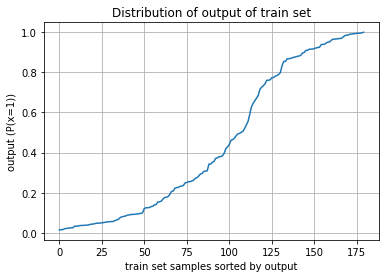

In [12]:
plt.plot(np.sort(trainProb3[:,1]))
plt.ylabel('output (P(x=1))')
plt.xlabel('train set samples sorted by output')
plt.title('Distribution of output of train set')
plt.grid(b=1)

The distribution is showing an s-curve. However, the curve is not very steep: there are a lot of samples around the 0.5 output. All these samples will cause a high penalization in the log loss function. We need a model that predicts more extreme -but correct- probabilities. So let's try a large margin classifier.

### SVM classifier with linear kernel

In [86]:
# model parameters
SVM1 = LinearSVC(dual=False, C=1)

# determine performance on crossval set
SVM_kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
crossVal_performance = np.zeros(SVM_kFold.get_n_splits())
i=int(0)
for iTrain, iCross in SVM_kFold.split(X, y):
    X_train, X_cross = X.iloc[iTrain], X.iloc[iCross]
    y_train, y_cross = y.iloc[iTrain], y.iloc[iCross]
    SVM_model_i = SVM1.fit(X_train, np.ravel(y_train))
    assign_class = SVM_model_i.predict(X_cross)
    class_prob = np.transpose([[0.999 if x==1 else 0.001 for x in assign_class]])  # we can't take log(0)
    crossVal_performance[i] = logLoss(y_cross, class_prob)
    i+=1
print('mean cross-validation performance: %0.5f' %np.mean(crossVal_performance))

# fit on all train data and give performance on train set
svmModel1 = SVM1.fit(X, np.ravel(y))
assign_class = svmModel1.predict(X)
class_prob = np.transpose([[0.999 if x==1 else 0.001 for x in assign_class]])
print('performance on train set is: %0.5f' %logLoss(y, class_prob))

mean cross-validation performance: 1.15213
performance on train set is: 0.88353


So it doesn't really seem like we improved our performance. Let's try optimizing the SVM kernel and parameters. 

### SVM optimization

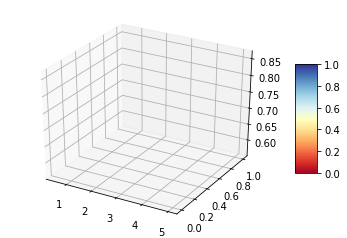

In [114]:
svc = SVC()
C = np.arange(0.5,5.5,0.5)
gamma = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
parameters = {'kernel':('linear', 'rbf'),'C':C, 'gamma':gamma}
search = GridSearchCV(svc, parameters, cv=10)
best_fit = search.fit(X, np.ravel(y))

# plot the results
params_grid = best_fit.cv_results_['params'][:]
C_grid = np.array([[sub_dict['C'] for sub_dict in params_grid]])
gamma_grid = np.array([[sub_dict['gamma'] for sub_dict in params_grid]])
test_perf_grid = np.array([best_fit.cv_results_['mean_test_score']])

fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d = ax.plot_surface(C_grid, gamma_grid, test_perf_grid, cmap=cm.RdYlBu, linewidth=0.1, antialiased=False)
fig.colorbar(plot3d, shrink=0.5, aspect=5)
plt.show()


# assign_class = best_fit.predict(X)
# class_prob = np.transpose([[0.999 if x==1 else 0.001 for x in assign_class]])
# print('performance on train set is: %0.5f' %logLoss(y,class_prob))

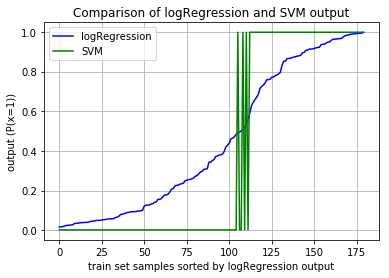

In [46]:
a, b = zip(*sorted(zip(trainProb3[:,1], class_prob)))

plt.plot(a, 'blue', label='logRegression')
plt.plot(b, 'green', label='SVM linear kernel')
plt.ylabel('output (P(x=1))')
plt.xlabel('train set samples sorted by logRegression output')
plt.title('Comparison of logRegression and SVM output')
plt.legend(loc='best')
plt.grid(b=1)

Well, we can see the SVM performs very similarly to logistic regression. In general, samples with a high probability output in Logistic Regression are classified as 1 in SVM, and those with low probability in LR are classified 0. In the middle it can be seen that the more ambiguous samples are chaotically classified 0 and 1 by the SVM. 

The big disadvantage of SVM in terms of our log loss function is of course that a single mis-classification immediately leads to an additional 0.017 to the loss. Maybe regression with SVM works better.

### SVM Regression with linear kernel

In [116]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
print(X)
print(Y)

[[-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 ...
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]]
[[-5.   -5.   -5.   ... -5.   -5.   -5.  ]
 [-4.75 -4.75 -4.75 ... -4.75 -4.75 -4.75]
 [-4.5  -4.5  -4.5  ... -4.5  -4.5  -4.5 ]
 ...
 [ 4.25  4.25  4.25 ...  4.25  4.25  4.25]
 [ 4.5   4.5   4.5  ...  4.5   4.5   4.5 ]
 [ 4.75  4.75  4.75 ...  4.75  4.75  4.75]]
